## 9. 폐렴아 기다려라!
# 폐렴 진단기 성능개선

### Step 1. 실험환경 Set-up

In [2]:
# 프로젝트에서 사용할 패키지 목록
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
# 필요한 변수들을 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE_16 = 16
BATCH_SIZE_32 = 32

EPOCHS_10 = 10
EPOCHS_25 = 25

print(ROOT_PATH)

/aiffel/aiffel


### Step 2. 데이터 준비하기

In [4]:
# 각 데이터들의 개수 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train : 5216개
- test : 624개
- val : 16개

#### 개수 비는 89%, 10.7%, 0.3%
- val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져옴.
- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할.

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- train : 4185개
- test : 624개
- val : 1047개
(test_size를 수정하면 개수는 달라질 수 있음.)

In [6]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


- 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있음.
- 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있음.

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


- 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있음.
- 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘함. - 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정.
- test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없음.

In [8]:
# tf.data 인스턴스 생성(tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해줌)
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

- 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높음.
- 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여보자.
- decode_img 함수와 process_path 함수 생성.
- process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경.
- get_label을 이용해서 라벨 값을 가져옴.

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

- train 데이터 셋과 validation 데이터 셋 생성.
- num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 줄 수 있음.

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
# 이미지 리사이즈 & 라벨 확인
for image, label in train_ds.take(1):  # train_ds.take(1) : 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
#  test 데이터셋 생성, 데이터 개수 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE_16)

print(TEST_IMAGE_COUNT)

624


- Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줌.
- tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환.

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택.

- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줌.

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.

- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE_16)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화
- 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출.
- 추출된 배치를 image와 label 데이터 셋으로 나눔.
- show_batch() 함수를 이용해서 결과 사진 확인.

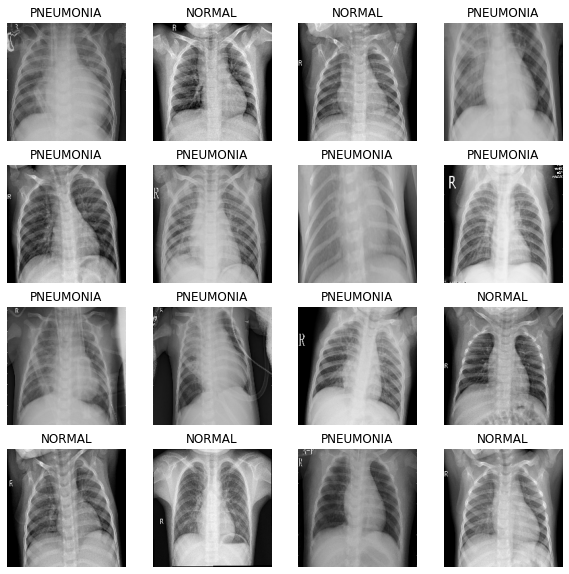

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE_16):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE_16/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링
이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보자.
1. Convolution block 생성.
2. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결.
3. Max Pooling을 함.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
# Dense Block 생성
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용.
- 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 함.
- variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있음.
- 그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 있음. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있음.

In [18]:
def build_model():
    model_1 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model_1

## Step 5. 데이터 imbalance 처리
- 'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었음.
- 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있음.

#### 이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됨. 
- Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법.
- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원. 

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


- weight_for_0은 'Normal' 이미지에 사용할 weight를 세팅.
- weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅.
- 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정.

## Step 6. 모델 훈련
- 이미지 훈련 : GPU를 사용할 것이기 때문에 먼저 GPU를 선택.
- 모델 : 위에서 만들었던 모델 함수인 build_model()을 model에 선언.

- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용.
- optimizer로 'adam'을 사용.
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용.

In [20]:
with tf.device('/GPU:0'):
    model_1 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
# 모델 fit (각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줌.)
# (모델 학습시 약 20분 이상 소요 됩니다.)

with tf.device('/GPU:0'):
    history_1 = model_1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_16,
        epochs=EPOCHS_10,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_16,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 78s 252ms/step - loss: 0.4288 - accuracy: 0.7768 - precision: 0.9514 - recall: 0.7375 - val_loss: 0.5776 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 69s 264ms/step - loss: 0.2517 - accuracy: 0.8932 - precision: 0.9710 - recall: 0.8828 - val_loss: 0.9331 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 67s 257ms/step - loss: 0.1835 - accuracy: 0.9313 - precision: 0.9812 - recall: 0.9253 - val_loss: 0.1678 - val_accuracy: 0.9317 - val_precision: 0.9971 - val_recall: 0.9099
Epoch 4/10
261/261 [==============================] - 68s 263ms/step - loss: 0.1814 - accuracy: 0.9322 - precision: 0.9813 - recall: 0.9267 - val_loss: 0.1454 - val_accuracy: 0.9510 - val_precision: 0.9931 - val_recall: 0.9399
Epoch 5/10
261/261 [==============================] - 69s 265ms/step - loss: 0.1842 - accura

## Step 7. 결과 확인과 시각화
- 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줌.

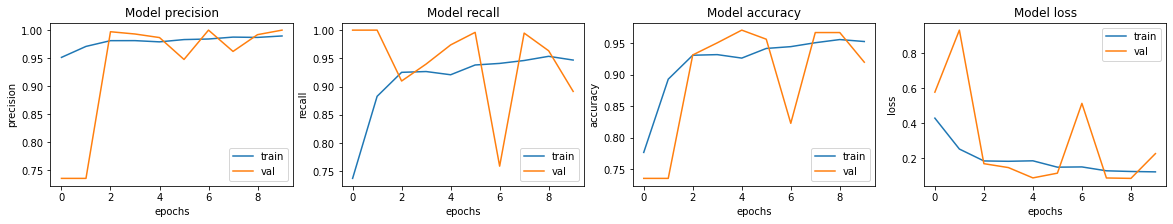

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_1.history[met])
    ax[i].plot(history_1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 테스트 데이터로 모델 평가.
- 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력.

In [23]:
loss, accuracy, precision, recall = model_1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 140ms/step - loss: 0.3926 - accuracy: 0.8670 - precision: 0.8545 - recall: 0.9487
Loss: 0.3925629258155823,
Accuracy: 0.8669871687889099,
Precision: 0.8545034527778625,
Recall: 0.9487179517745972


##  폐렴 진단기 성능개선
#### model_1 : Accuracy: 86.69%
* BATCH_SIZE_16 = 16
* EPOCHS_10 = 10

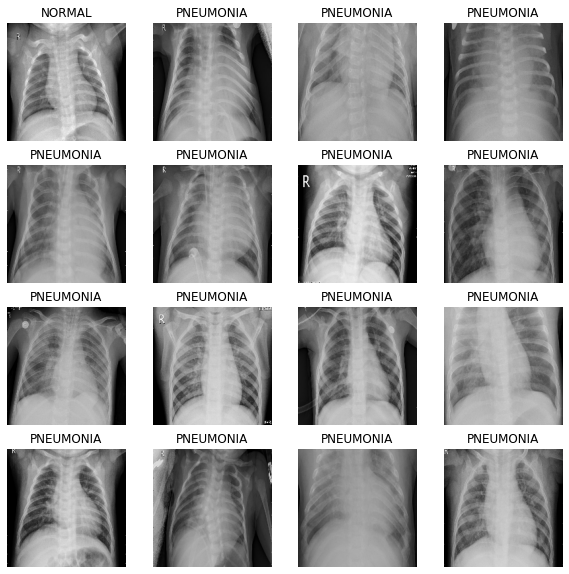

In [24]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE_16):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE_16/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [25]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [26]:
# Dense Block 생성
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [27]:
def build_model():
    model_2 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model_2

In [28]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [29]:
with tf.device('/GPU:0'):
    model_2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
# 모델 fit (각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줌.)
# (모델 학습시 약 20분 이상 소요 됩니다.)

with tf.device('/GPU:0'):
    history_2 = model_2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_16,
        epochs=EPOCHS_25,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_16,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 59s 192ms/step - loss: 0.4544 - accuracy: 0.7799 - precision: 0.9408 - recall: 0.7516 - val_loss: 0.6735 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2595 - accuracy: 0.8977 - precision: 0.9698 - recall: 0.8900 - val_loss: 1.2010 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 53s 204ms/step - loss: 0.2274 - accuracy: 0.9136 - precision: 0.9741 - recall: 0.9080 - val_loss: 0.2678 - val_accuracy: 0.8635 - val_precision: 0.8442 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 50s 190ms/step - loss: 0.1986 - accuracy: 0.9222 - precision: 0.9764 - recall: 0.9176 - val_loss: 0.3203 - val_accuracy: 0.8548 - val_precision: 0.8375 - val_recall: 0.9961
Epoch 5/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1700 - accura

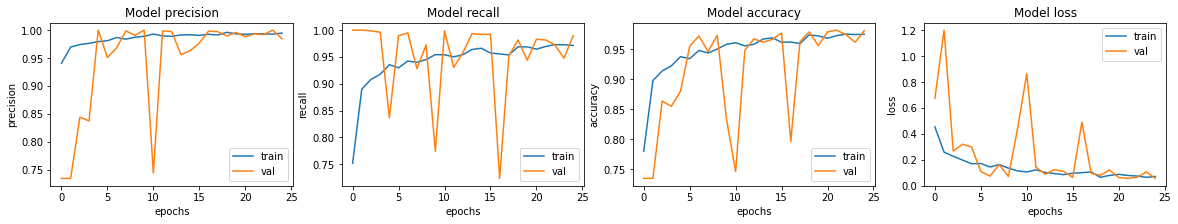

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_2.history[met])
    ax[i].plot(history_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
    

In [32]:
loss, accuracy, precision, recall = model_2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 120ms/step - loss: 1.2983 - accuracy: 0.7404 - precision: 0.7080 - recall: 0.9949
Loss: 1.2982699871063232,
Accuracy: 0.7403846383094788,
Precision: 0.7080292105674744,
Recall: 0.9948717951774597


##  폐렴 진단기 성능개선
####  model_2 : Accuracy: 74.03%
* BATCH_SIZE = 16 (유지)
* EPOCHS = 25 (10→25 변경)

In [14]:
#  test 데이터셋 생성, 데이터 개수 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE_16)

print(TEST_IMAGE_COUNT)

624


In [15]:
# 좌우 반전 정도의 augmentation만 도입
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE_16)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

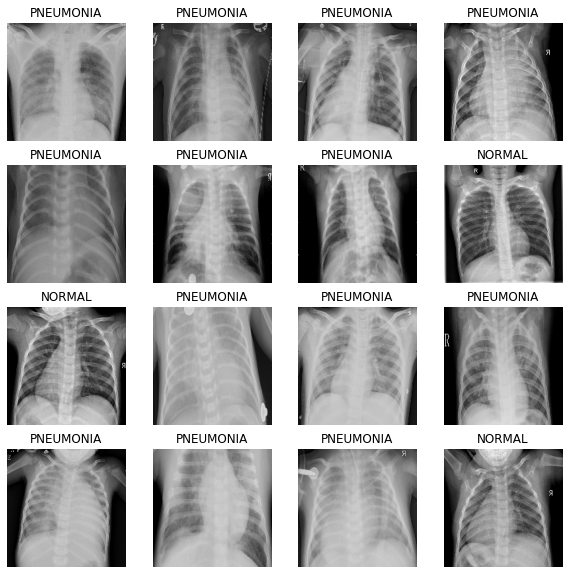

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE_16):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE_16/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
# Dense Block 생성
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model_3 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model_3

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [22]:
with tf.device('/GPU:0'):
    model_3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
# 모델 fit (각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줌.)
# (모델 학습시 약 20분 이상 소요 됩니다.)

with tf.device('/GPU:0'):
    history_3 = model_3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_16,
        epochs=EPOCHS_25,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_16,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 64s 193ms/step - loss: 0.4069 - accuracy: 0.7929 - precision: 0.9517 - recall: 0.7602 - val_loss: 0.6309 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2404 - accuracy: 0.9073 - precision: 0.9690 - recall: 0.9044 - val_loss: 1.5848 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 52s 200ms/step - loss: 0.2049 - accuracy: 0.9193 - precision: 0.9743 - recall: 0.9157 - val_loss: 0.2594 - val_accuracy: 0.8721 - val_precision: 0.8517 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1876 - accuracy: 0.9349 - precision: 0.9783 - recall: 0.9329 - val_loss: 0.0662 - val_accuracy: 0.9740 - val_precision: 0.9868 - val_recall: 0.9778
Epoch 5/25
261/261 [==============================] - 55s 212ms/step - loss: 0.1968 - accura

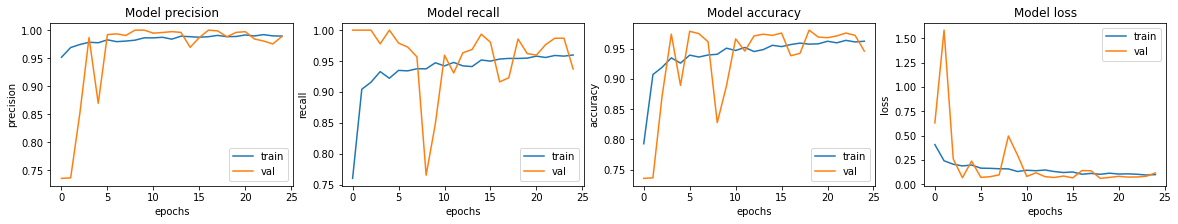

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_3.history[met])
    ax[i].plot(history_3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model_3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 152ms/step - loss: 1.1317 - accuracy: 0.7564 - precision: 0.7371 - recall: 0.9487
Loss: 1.1317387819290161,
Accuracy: 0.7564102411270142,
Precision: 0.737051784992218,
Recall: 0.9487179517745972


##  폐렴 진단기 성능개선
#### model_3 : Accuracy: 75.64%
* BATCH_SIZE = 16 (유지)
* EPOCHS = 25 (유지)
* 좌우 반전 정도의 augmentation만 도입

In [15]:
#  test 데이터셋 생성, 데이터 개수 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE_16)

print(TEST_IMAGE_COUNT)

624


In [16]:
# 좌우 반전 정도의 augmentation만 도입
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE_16)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

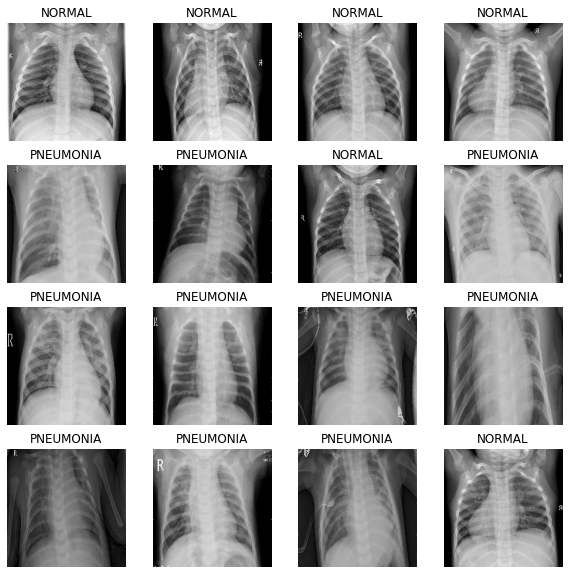

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE_16):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE_16/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
# Dense Block 생성
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model_4 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model_4

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [22]:
with tf.device('/GPU:0'):
    model_4 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
# 모델 fit (각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줌.)
# (모델 학습시 약 20분 이상 소요 됩니다.)

with tf.device('/GPU:0'):
    history_4 = model_4.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_16,
        epochs=EPOCHS_10,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_16,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 65s 195ms/step - loss: 0.3938 - accuracy: 0.8144 - precision: 0.9498 - recall: 0.7923 - val_loss: 0.6393 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 50s 191ms/step - loss: 0.2489 - accuracy: 0.9088 - precision: 0.9687 - recall: 0.9067 - val_loss: 1.4811 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 51s 195ms/step - loss: 0.2194 - accuracy: 0.9179 - precision: 0.9753 - recall: 0.9128 - val_loss: 0.1384 - val_accuracy: 0.9356 - val_precision: 0.9194 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 51s 196ms/step - loss: 0.1862 - accuracy: 0.9310 - precision: 0.9786 - recall: 0.9275 - val_loss: 0.1533 - val_accuracy: 0.9500 - val_precision: 0.9972 - val_recall: 0.9348
Epoch 5/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1847 - accura

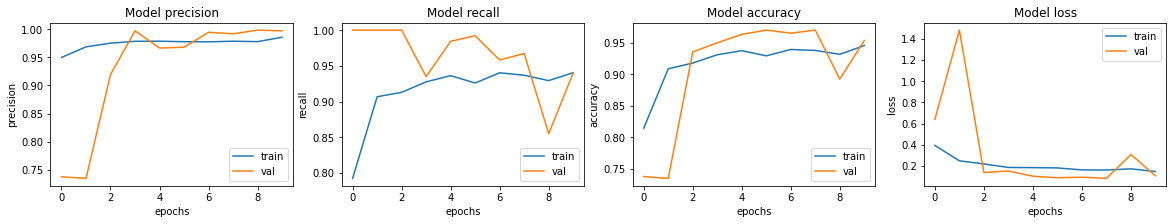

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_4.history[met])
    ax[i].plot(history_4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model_4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 150ms/step - loss: 0.4052 - accuracy: 0.8542 - precision: 0.8271 - recall: 0.9692
Loss: 0.4051777422428131,
Accuracy: 0.8541666865348816,
Precision: 0.8271334767341614,
Recall: 0.9692307710647583


##  폐렴 진단기 성능개선
#### model_4 : Accuracy: 85.41%
* BATCH_SIZE = 16 (유지)
* EPOCHS = 10 
* 좌우 반전 정도의 augmentation만 도입

## 회고

#### model_1 : Accuracy: 86.69%
* BATCH_SIZE_16 = 16
* EPOCHS_10 = 10
Loss: 0.3925629258155823,
Accuracy: 0.8669871687889099,
Precision: 0.8545034527778625,
Recall: 0.9487179517745972

#### model_2 : Accuracy: 74.03%
* BATCH_SIZE = 16 (유지)
* EPOCHS = 25 (10→25 변경)
Loss: 1.2982699871063232,
Accuracy: 0.7403846383094788,
Precision: 0.7080292105674744,
Recall: 0.9948717951774597

#### model_3 : Accuracy: 75.64%
* BATCH_SIZE = 16 (유지)
* EPOCHS = 25 (유지)
* 좌우 반전 정도의 augmentation만 도입
Loss: 1.1317387819290161,
Accuracy: 0.7564102411270142,
Precision: 0.737051784992218,
Recall: 0.9487179517745972

#### model_4 : Accuracy: 85.41%
* BATCH_SIZE = 16 (유지)
* EPOCHS = 10 
* 좌우 반전 정도의 augmentation만 도입
Loss: 0.4051777422428131,
Accuracy: 0.8541666865348816,
Precision: 0.8271334767341614,
Recall: 0.9692307710647583


model_1,2 돌리고 model_3 돌리다가 커널이 두번 죽고 마지막 model_3을 기대하며 돌렸는데 Accuracy이 75% 여서 실망..제일 처음 모델의 Accuracy이 제일 높았다.
에폭이 10 정도여서 성능이 높게 나온건가 싶어서 같은 조건으로 에폭을 10으로 두고 시도해봤다.
기존의 실습코드에서 에폭 횟수를 10으로 했을 때 다른 시도들보다 성능이 좋게 나왔다.

폐렴 분류도 유방암 분류처럼 폐렴인데 폐렴이 아니라고 판단하면 안되기 때문에 recall이 중요하다고 생각한다. model_1, 2, 3, 4 대부분 recall이 94% 이상이였다.
그 중에 Accuracy이 75% 미만인 model_2, 3은 성능이 좋지 않다고 본다.